## Stability - using barycentric interpolation

In [196]:
using CairoMakie

# Barycentric interpolation and background information

The barycentric formula is:
```math
```

# Basis - ```j_eval``` function

For interpolation points/nodes, $x_j$, and some new points $x_i$, that you want to find $f(x_i)$. The  ```j_eval``` function is used to find the matrix 
```math
E_{ij}=\ell_j(x_i)
```
such that 
```math
\textbf{f}(\textbf{x}_i)=\frac{E *\textbf{f}}{E *\mathbf{1}}
```
The formula the function ```j_eval``` uses for $\ell_j(x)$ is:
```math
\ell_j(x)=\frac{\frac{w_j}{x-x_j}}{\sum_{k=0}^{n} \frac{w_k}{x-x_k}}
```
While the user can give any interpolation point $x_j$, for large N the user must ensure the points are clustered more heavily at the interval boundaries to ensure an appropriate/well-defined interpolation. For ease, all my examples use a common set of interpolation points, $x_j$, called the Chebyshev points of the second kind, whose formula are:

```math
x_j=\cos \frac{j \pi}{n}, j=0,...,n

```
They have the explicit weight formula: 
```math
w_j=(-1)^j \delta_j,
\delta_j=
\begin{cases}
\frac{1}{2}, & \text{j=0 or j=n}\\
1, & \text{otherwise}
\end{cases}
```
However, while my examples use Chebyshev points of the 2nd kind, the function ```j_eval``` can take any $x_j$ values and find their weights. The  ```j_eval``` function finds the matrix $E$ and does so for any points given by the user by finding the weights given the interpolation points $x_j$.

We'll try with using a function $f(x)=\cos(x)$, where we want the value of $\cos(0.5)$ and $\cos(0.75)$ (our $x_i$ are 0.5 and 0.75)

Below we demonstrate the use of function ```j_eval```:

In [197]:
include("j_eval.jl")
include("j_diff.jl")
#include("../shared/j_eval.jl")
#include("../shared/j_diff.jl")

n=200 #so we have 201 interpolation/Chebyshev points
xjvals=cos.(pi*(0:n)'/n)[:] #interpolation points in the form of chebyshev points of the 2nd kind
xivals=[0.5,0.75] #points you want to evaluate at
fvec=cos.(xjvals)[:]#fj values 

emat=j_eval(xjvals,xivals) #E matrix of lj(xi) components
fxivals2=(emat*fvec)

2-element Vector{Float64}:
 0.8775825618903724
 0.7316888688738207

In [198]:
#To check my function works we'll find the true value of f(xivals)
true_fxi=cos.([0.5,0.75])

2-element Vector{Float64}:
 0.8775825618903728
 0.7316888688738209

In [199]:
#Plot error for varying n
xivals=[0.5,0.75] #points you want to evaluate at
ni=[1:1:150;] #a sequence of increasing n from 1 to 150
max_error=fill(NaN, length(ni))
for k in 1:length(ni)
    xjvals_ni=cos.(pi*(0:ni[k])'/ni[k])[:] #interpolation points in the form of chebyshev points of the 2nd kind or n=ni[k]
    fvec_ni=cos.(xjvals_ni)[:]#fj values for xj values given n=ni[k]
    emat_ni=j_eval(xjvals_ni,xivals) #E matrix of lj(xi) components
    fxivals_ni=(emat_ni*fvec_ni)#finds estimated value of f(xi) using interpolation (polynomial)
    max_error[k]=findmax(abs.(fxivals_ni-true_fxi))[1] #finds maximum error between approximated f(xi) and the true f(xi)
end 

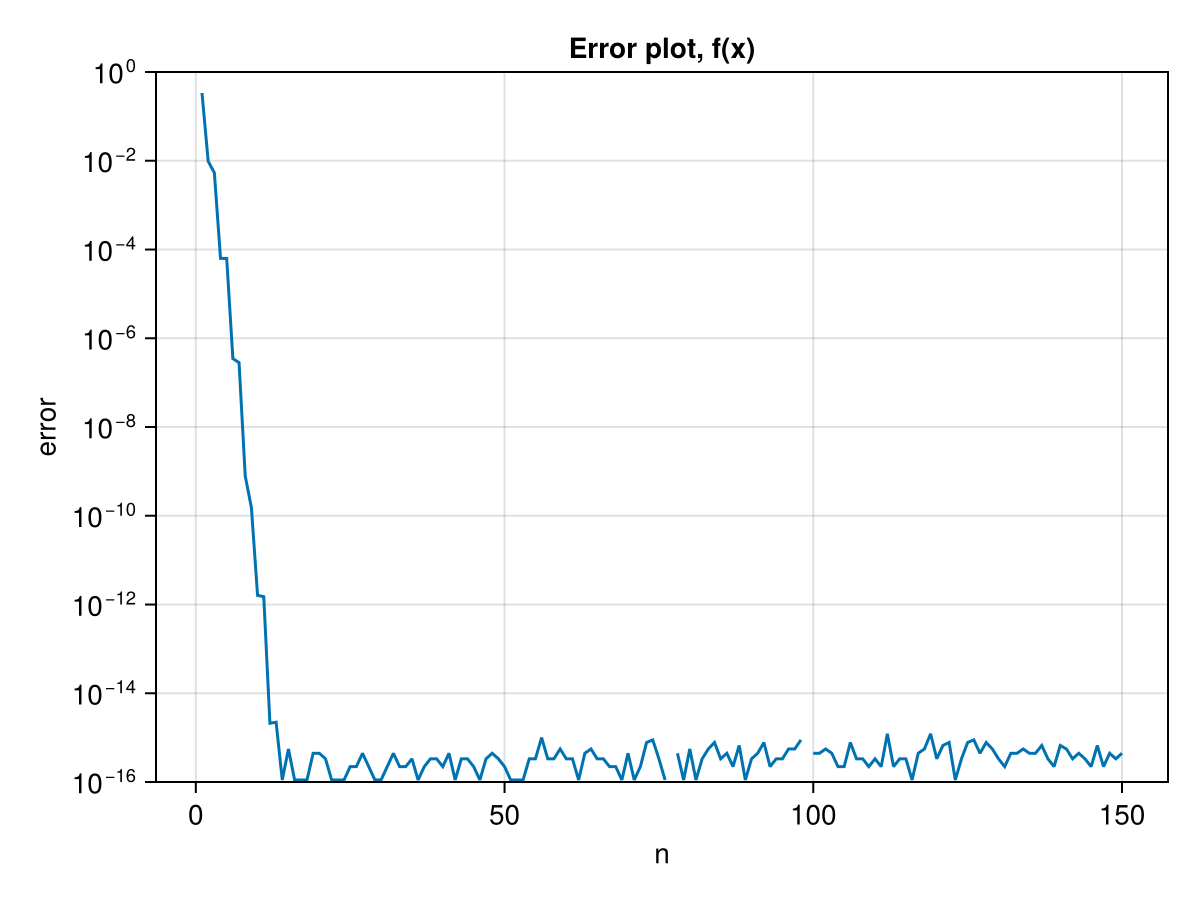

In [200]:
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="n",ylabel="error", title="Error plot, f(x)", yscale=log10) #Axis(fig1[1,1],xlabel="x",ylabel="f(x)",title="n=200")
lines!(ax1,ni,max_error)
ylims!(ax1,[1e-16,1])
fig1

In [201]:
xivals=[0.5,0.75] #points you want to evaluate at
ni=[1:1:150;] #a sequence of increasing n from 1 to 150
max_error2=fill(NaN, length(ni))
f(x)=1/(1 +16*x^2)
true_fxi2=f.(xivals)
for k in 1:length(ni)
    xjvals_ni=cos.(pi*(0:ni[k])'/ni[k])[:] #interpolation points in the form of chebyshev points of the 2nd kind or n=ni[k]
    fvec_ni2=f.(xjvals_ni)[:]#fj values for xj values given n=ni[k]
    emat_ni2=j_eval(xjvals_ni,xivals) #E matrix of lj(xi) components
    fxivals_ni2=(emat_ni2*fvec_ni2)#finds estimated value of f(xi) using interpolation (polynomial)
    max_error2[k]=findmax(abs.(fxivals_ni2-true_fxi))[1] #finds maximum error between approximated f(xi) and the true f(xi)
end 

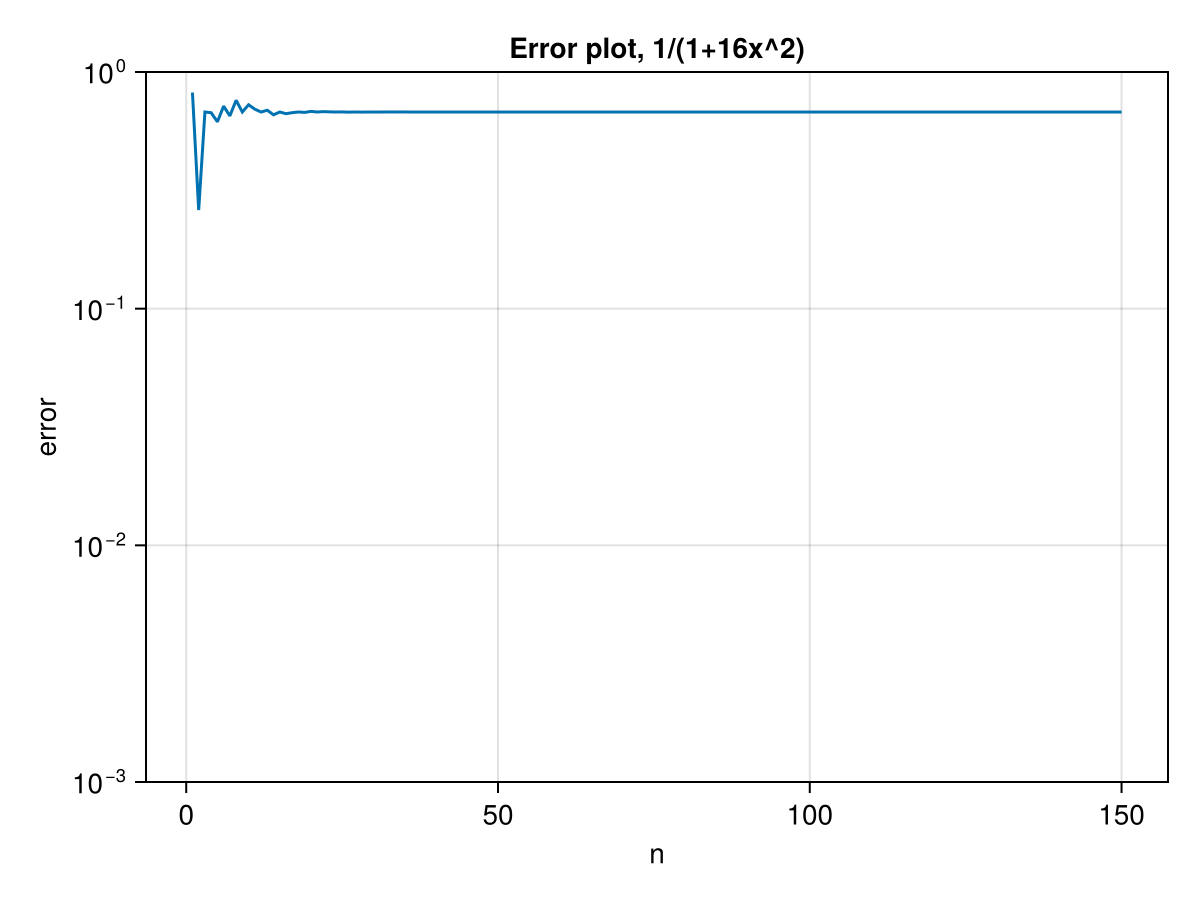

In [202]:
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="n",ylabel="error", title="Error plot, 1/(1+16x^2)", yscale=log10) #Axis(fig1[1,1],xlabel="x",ylabel="f(x)",title="n=200")
lines!(ax2,ni,max_error2)
ylims!(ax2,[1e-3,1])
fig2

Next we'll look at another, more complicated example. The next example we'll look at is:
```math
f(x)=|x|+\frac{x}{2} -x^2
```

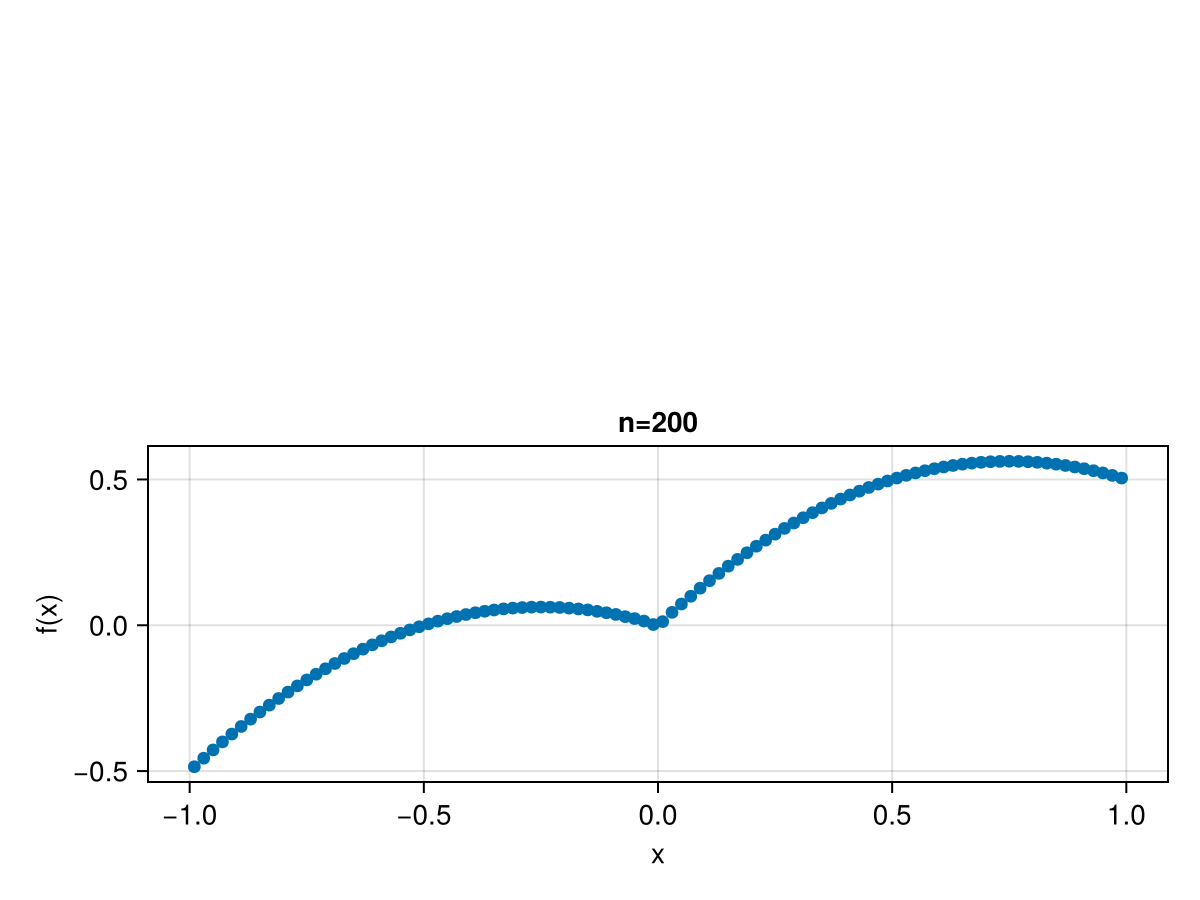

In [203]:
include("binter_example.jl")
n=200 #so we have 201 interpolation/Chebyshev points
xjvals=cos.(pi*(0:n)'/n)[:] 
xivals2=[-0.99:0.02:0.99;]
fvec2=binter_example(xjvals) #(xivals2)

emat2=j_eval(xjvals,xivals2) #E matrix of lj(xi) components
fxivals2=(emat2*fvec2)#./(emat4*vec1)

fig2=Figure()
ax2=Axis(fig2[2,1],xlabel="x",ylabel="f(x)",title="n=200") #Axis(fig1[1,1],xlabel="x",ylabel="f(x)",title="n=200")
scatter!(ax2,xivals2,fxivals2)
fig2


# Differentiating

In [217]:
include("j_eval.jl")
n=200 #so we have 201 interpolation/Chebyshev points

diffmat=j_eval(xjvals,xivals,diff=1) #E matrix of lj(xi) components
dfxivals=diffmat*fvec#uses barycentric interpolation formula to find p(xivals)
#dfxivals[1:5]

2-element Vector{Float64}:
 -0.4794255386041693
 -0.6816387600233019

In [230]:
#Compare the above to the true values of f'(x_j) -> remember x_j are the interpolation points
#diff_exact=-sin.(xjvals)[1:5]
diff_exact=-sin.(xivals)

2-element Vector{Float64}:
 -0.479425538604203
 -0.6816387600233341

In [ ]:
#Find the derivative f'(0.5), f'(0.75) for f(x)=cos(x)
#emat# E_ij matrix for the relevant lj(xi) values

#fderivvals=emat*diffmat*fvec

DimensionMismatch: DimensionMismatch: second dimension of A, 201, does not match length of x, 2

In [ ]:
#f'(x)=-sin(x)
#true_derivvals=-sin.(xivals)

2-element Vector{Float64}:
 -0.479425538604203
 -0.6816387600233341

In [260]:
#Finding f''(0.5), f''(0.75) for f(x)=cos(x)
#d2fvals=emat*diffmat*diffmat*fvec
D2=j_eval(xjvals,xivals,diff=2)
d2fvals=D2*fvec

2-element Vector{Float64}:
 -0.8775825627021878
 -0.7316888688605298

In [261]:
#f''(x)=-cos(x)
true_d2fvals=-cos.(xivals)

2-element Vector{Float64}:
 -0.8775825618903728
 -0.7316888688738209

In [262]:
#diff2mat=j_eval(xjvals,xivals,diff=2) #E matrix of lj(xi) components
#df2xivals=diff2mat*fvec#uses barycentric interpolation formula to find p(xivals)
#df2xivals[1:5] #would expect them to be -ve fvec

# Stability using barycentric interpolation - Breda et al 2009 method

The stability of an equilibrium point can be found using barycentric interpolation. The function ```stab_func_bi``` uses barycentric interpolation to find the stability and the rightmost eigenvalue of an equilibrium point. Below is an example for a delay differential equation system that models the interaction between two neurons. A more indepth look at this system can be found in the Neuron_example demo but it's system is given by:
```math
\begin{align}
  \dot{x}_1&= -\kappa x_1(t) + \beta \tanh(x_1(t-\tau_s)) + a_{12} \tanh(x_2(t-\tau_2))\\
  \dot{x}_2&=-\kappa x_2(t) + \beta \tanh(x_2(t-\tau_s)) + a_{21} \tanh(x_2(t-\tau_1))
\end{align}
```

In [263]:
using LinearAlgebra
#Use these when notebook not in its own folder
include("Neuron_demo/neuronfunc.jl") #system of neuron example
include("Neuron_demo/neurontau.jl") #Delay forumla for neuron example
include("shared/f_deriv.jl") #used to find state and/or parameter derivatives
include("shared/jacobian.jl") #Jacobian function
include("shared/newton.jl") #Newton function
include("shared/create_ststfunc.jl") #Initialisates a function to find equilibria 
include("shared/track_curve.jl") #Tracking curve function (used for continuation and equilibria branches)
include("shared/create_hopffunc.jl")#finds initial guess for Hopf information and creates a function that can find the true Hopf values
#include("stab_func_bi.jl")#finds stability and rightmost eigenvalue using barycentric interpolation

#USe the ones below when you have moved this notebook into its own folder
#include("../Neuron_demo/neuronfunc.jl") #system of neuron example
#include("../Neuron_demo/neurontau.jl") #Delay forumla for neuron example
#include("../shared/f_deriv.jl") #used to find state and/or parameter derivatives
#include("../shared/jacobian_new.jl") #Jacobian function
#include("../shared/newton_new.jl") #Newton function
#include("../shared/create_ststfunc.jl") #Initialisates a function to find equilibria 
#include("../shared/track_curve_new.jl") #Tracking curve function (used for continuation and equilibria branches)
#include("../shared/create_hopffunc.jl")#finds initial guess for Hopf information and creates a function that can find the true Hopf values
#include("../shared/stab_func_bi.jl")#finds stability and rightmost eigenvalue using barycentric interpolation

create_hopffunc (generic function with 1 method)

In [264]:
#Values of parameters (same as those given in the neuron demo for DDE-Biftool)
k=0.5
beta=-1
a12=1
a21=2.34 
tau1=0.2
tau2=0.2
taus=1.5

nd=3 #there are 3 delays
y0,feq=create_ststfunc(neuronfunc,[0.0,0],[k,beta,a12,0,tau1,tau2,taus], nd, par_indx=4) #we set a21 to 0 and finding starting point for equilibria branching
alist1,ytan1=track_curve_new(feq,y0,[0.0,0,1],nmax=550)#tracks equilibria to give equilibria branch

xmat1=hcat([u[1] for u in alist1],[u[2] for u in alist1]); #finds the values of x1 and x2 for the equilibria
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)];#creates a vector of vectors of all the equilibria points


plist1=[u[3] for u in alist1]; #A vector of the values of a21 for the equilibria points


UndefVarError: UndefVarError: `track_curve_new` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [265]:
neq=length(plist1) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)
lamr1=fill(0.0+0.0*im,neq)

for i in 1:neq
    stab[i],lamr1[i],=stab_func_bi(neuronfunc,neurontau,[k,beta,a12,plist1[i],tau1,tau2,taus],xlist1[i],3,10) #outputs the stability (1 for stable, 0 for unstable) and also gives the rightmost eigenvalue for each equilibrium point
end

stable=(stab.==1.0) #highlights indices of stable points (indicated by a 1 in stable vector)
unstable=(stab.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="a₂₁",ylabel="x")
scatter!(ax1,plist1[stable],[u[1] for u in xlist1[stable]],label="stable",color="green")
scatter!(ax1,plist1[unstable],[u[1] for u in xlist1[unstable]],label="unstable",color="red")
Legend(fig1[1,2], ax1, merge=true)
fig1

UndefVarError: UndefVarError: `plist1` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [266]:
unstab_indx=findfirst(isequal(0.0),stab) #finds index of Hopf bifurcation
a21unstab=plist1[unstab_indx] #finds initial guess for parameter a21 value for a Hopf bifurcation

UndefVarError: UndefVarError: `stab` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [267]:
#create_hopffunc uses stab_func (old stability function - need to amend this)
yh01,fhopf=create_hopffunc(neuronfunc,neurontau,[k,beta,a12,0,tau1,tau2,taus],xlist1[unstab_indx],[a21unstab],[4],3,stabtype="bi",N_num=10) #outputs initial guess of the Hopf bifurcation (including x, ω and a21 estimates) and a function that contians the method/formula to find the Hopf bifurcation
println("The initial guess for Hopf info: $yh01")
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=newton_new(fhopf,yh01) #putting initial guess and Hopf function into newton we get the true parameter values and information for the Hopf bifurcation
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
a_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1:2]
println("The ω value for hopf bifurcation: $om_hopf")
println("The a21 value for hopf bifurcation: $a_hopf")

UndefVarError: UndefVarError: `xlist1` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Below is an broken-down example for a linearised 2D system to aid understanding of how the inner working of ```stab_func_bi``` work. 

ANNOTATE AND COMMENT ON THE CODE BELOW!!!!!!!

In [268]:
###For m=2 with 2 delays tau1 and tau2
m=2
Id2=Matrix{Float64}(I,2,2)

tau1=0.2
tau2=0.3
taumaxtrial2=0.3
N2=14

tjvals2=reverse((-taumaxtrial2/2)*(cos.(pi*(0:N2)'/N2)[:].+1))
ljvals2=j_eval(tjvals2,[0,-tau1,-tau2])
Dtrial2=j_eval(tjvals2,[0,-taumaxtrial2],diff=1)
stabmatrixAtrial2=fill(NaN,m*(N2+1),m*(N2+1))
mD2mat=fill(NaN,m*N2,m*(N2+1))
for i in 2:N2+1
    for j in 1:N2+1
        mD2mat[2*i-3:2*i-2,2*j-1:2*j]=Id2*Dtrial2[i,j]
    end 
end 

stabmatrixAtrial2[m+1:end,1:end]=mD2mat

M1=[-6.45 -12.1; 1.5 -0.45]
M2=[-6 0; 1 0]
M3=[0 4; 0 -2]

for j in 1:N2+1
    stabmatrixAtrial2[1:m,2*j-1:2*j]=M1*(ljvals2[1,j]*Id2)+M2*(ljvals2[2,j]*Id2)+M3*(ljvals2[3,j]*Id2) #indices would change for different m (m!=0)
end 

eigvals(stabmatrixAtrial2) #rightmost eigenvalue matches the one in Breda source!!!

BoundsError: BoundsError: attempt to access 2×15 Matrix{Float64} at index [3, 1]